In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:

# ---------------------------
# 1. 数据处理
# ---------------------------

data_path = 'Data2/data2024.csv'
df = pd.read_csv(data_path)
target_col = "Temperature"
num_features = df.shape[1]  # 输入数据的特征数目

In [3]:
print(num_features)

10


In [4]:

# 按时间顺序划分训练集和测试集
train_size = int(0.8 * len(df))
df_train = df.iloc[:train_size].reset_index(drop=True)
df_test = df.iloc[train_size:].reset_index(drop=True)

# 标准化数据（只用训练集拟合）
scaler = StandardScaler()
scaler.fit(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)


In [5]:

# ---------------------------
# 2. 数据集类
# ---------------------------

class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col, seq_len, pred_steps):
        self.data = data.values
        self.seq_len = seq_len
        self.pred_steps = pred_steps
        self.target_idx = data.columns.get_loc(target_col)
        self.num_samples = len(data) - seq_len - pred_steps + 1

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        X = self.data[idx: idx + self.seq_len, :]
        y = self.data[idx + self.seq_len: idx + self.seq_len + self.pred_steps, self.target_idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [7]:

# ---------------------------
# 3. 模型定义：带因果关系和注意力机制的LSTM
# ---------------------------

class AttentionLSTMWithCausal(nn.Module):
    def __init__(self, num_features, hidden_size, d_a, output_size, causal_tensor, segments, target_idx,
                 lambda_causal=1, num_layers=1, topk=3):
        """
        参数说明：
         - num_features: 输入特征的维数 (N)
         - hidden_size: LSTM隐藏状态维数
         - d_a: 注意力机制中隐藏层的维数
         - output_size: LSTM输出层的输出维数（预测步长）
         - causal_tensor: 因果关系矩阵，形状为 (num_segments, N, N)
         - segments: 窗口划分列表，每个窗口定义为 (start, end)
         - target_idx: 目标变量在输入特征中的索引
         - lambda_causal: 因果关系调整系数
         - num_layers: LSTM层数
         - topk: 每个时间步保留的 top-K 特征数量
        """
        super(AttentionLSTMWithCausal, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.topk = topk

        # 注册因果关系张量，形状: (num_segments, N, N)
        self.register_buffer("causal_tensor", torch.tensor(causal_tensor, dtype=torch.float32))
        self.segments = segments
        self.lambda_causal = lambda_causal
        self.target_idx = target_idx

        # 注意力机制的全连接层：计算每个特征的注意力得分
        self.attention_W_h = nn.Linear(hidden_size, d_a)
        self.attention_W_x = nn.Linear(num_features, d_a)  # 对整行输入进行线性变换
        self.attention_v = nn.Linear(d_a, 1)  # 输出标量得分

        # LSTM 模块，输入维度为 num_features
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        输入 x: (batch_size, seq_len, num_features)
        输出:
         - output: (batch_size, output_size)
         - att_weights: (batch_size, seq_len, num_features) 每个时间步各特征的注意力权重
        """
        batch_size, seq_len, num_features = x.size()
        att_weights_seq = []  # 存储每个时间步的注意力权重
        lstm_inputs = []  # 存储每个时间步经过注意力加权后的特征向量

        # 初始化 LSTM 隐状态和细胞状态
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        for t in range(seq_len):
            # 当前时间步的输入 x_t: (batch_size, num_features)
            x_t = x[:, t, :]  # (B, N)
            h_last = h[-1]  # (B, hidden_size)
            # 将 h_last 扩展为 (B, N, hidden_size)
            h_last_exp = h_last.unsqueeze(1).expand(-1, num_features, -1)  # (B, N, H)

            # 对 x_t 进行全连接变换，得到 (B, d_a)
            x_t_trans = self.attention_W_x(x_t)  # (B, d_a)
            # 扩展为 (B, N, d_a)
            x_t_trans_exp = x_t_trans.unsqueeze(1).expand(-1, num_features, -1)  # (B, N, d_a)

            # 对 h_last 进行全连接变换，得到 (B, N, d_a)
            h_trans = self.attention_W_h(h_last_exp)  # (B, N, d_a)

            # 计算注意力得分
            score = torch.tanh(h_trans + x_t_trans_exp)  # (B, N, d_a)
            e = self.attention_v(score).squeeze(-1)  # (B, N)，每个特征的得分

            # 加入因果关系调整
            segment_idx = self.find_segment(t)
            causal_row = self.causal_tensor[segment_idx, self.target_idx, :]  # (N,)
            causal_row = causal_row.unsqueeze(0).expand(batch_size, -1)  # (B, N)
            e_adjusted = e + self.lambda_causal * causal_row

            # Top-K 筛选：只保留每个样本中 K 个最大的得分，其余位置置为 -infty
            topk_vals, topk_idx = torch.topk(e_adjusted, self.topk, dim=1)
            mask = torch.full_like(e_adjusted, float('-inf'))
            mask.scatter_(1, topk_idx, e_adjusted.gather(1, topk_idx))

            # 使用 mask 后进行 softmax，只有 top-K 位置获得非零概率
            modified_alpha = torch.softmax(mask, dim=1)  # (B, N)
            att_weights_seq.append(modified_alpha)

            # 用修改后的注意力权重加权 x_t（逐元素相乘）
            x_t_att = modified_alpha * x_t  # (B, N)
            lstm_inputs.append(x_t_att)

        # 将所有时间步的加权特征堆叠，形成 LSTM 输入，形状 (B, seq_len, N)
        lstm_input_seq = torch.stack(lstm_inputs, dim=1)

        # LSTM 前向传播
        out, (h, c) = self.lstm(lstm_input_seq, (h, c))
        final_hidden = h[-1]  # (B, hidden_size)
        output = self.fc(final_hidden)  # (B, output_size)

        # 将各时间步的注意力权重堆叠, 形状 (B, seq_len, N)
        att_weights = torch.stack(att_weights_seq, dim=1)
        return output, att_weights

    def find_segment(self, t):
        for idx, (start, end) in enumerate(self.segments):
            if start <= t < end:
                return idx
        return len(self.segments) - 1  # 如果 t 超出所有段，则返回最后一个段的索引


In [8]:

# ---------------------------
# 4. 超参数设置与数据加载
# ---------------------------

seq_len = 10  # 输入序列长度
pred_steps = 1  # 预测步长
batch_size = 64
num_epochs = 50
learning_rate = 0.001

# 加载因果关系数据，假定 causal_tensor.npy 的形状为 (num_segments, N, N)
causal_tensor = np.load('causal_tensor.npy')
segments = [(0, 1841), (1841, 3471), (3471, 4757), (4757, 6575)]

train_dataset = TimeSeriesDataset(df_train_scaled, target_col, seq_len, pred_steps)
test_dataset = TimeSeriesDataset(df_test_scaled, target_col, seq_len, pred_steps)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

target_idx = df.columns.get_loc("Wind_Speed")

model = AttentionLSTMWithCausal(
    num_features=num_features,
    hidden_size=64,
    d_a=32,
    output_size=pred_steps,
    causal_tensor=causal_tensor,
    segments=segments,
    target_idx=target_idx,
    lambda_causal=1,
    topk=3  # 设置每个时间步保留 top-3 特征
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Causal tensor shape:", causal_tensor.shape)

Causal tensor shape: (4, 10, 10)


In [20]:
from skopt.utils import use_named_args
from skopt import BayesSearchCV, gp_minimize
import skopt
from sklearn.metrics import r2_score
#超参数空间
SPACE = [
    skopt.space.Real(0.001,0.1,name='learning_rate',prior='log-uniform'),
    skopt.space.Integer(10,64,name='seq_len'),
    skopt.space.Integer(16,128,name='hidden_size'),
    skopt.space.Integer(16,128,name='d_a'),
    skopt.space.Integer(3,5,name='top_k'),
    skopt.space.Real(0.1,10,name='lambda_causal'),
]
@use_named_args(SPACE)
def TVCAD_LSTM_TEST(learning_rate,seq_len,hidden_size,d_a,top_k,lambda_causal): 
    #固定参数
    causal_tensor = np.load('causal_tensor.npy')
    segments = [(0, 1841), (1841, 3471), (3471, 4757), (4757, 6575)]
    pred_steps = 1
    batch_size = 64
    seq_len = seq_len
    num_epochs = 50
    num_layers=1
    learning_rate = learning_rate
    train_dataset = TimeSeriesDataset(df_train_scaled, target_col, seq_len, pred_steps)
    test_dataset = TimeSeriesDataset(df_test_scaled, target_col, seq_len, pred_steps)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    target_idx = df.columns.get_loc("Temperature")

    
    model = AttentionLSTMWithCausal(
        num_features=num_features,
        hidden_size=int(hidden_size),
        d_a=int(d_a),
        output_size=pred_steps,
        causal_tensor=causal_tensor,
        segments=segments,
        target_idx=target_idx,
        lambda_causal=int(lambda_causal),
        topk=int(top_k)  # 设置每个时间步保留 top-3 特征
    )   

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs, att_weights = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {np.mean(epoch_losses):.4f}")
       
    model.eval()
    predictions = []
    ground_truth = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output, att_weights = model(X_batch)
            predictions.append(output.cpu().numpy())
            ground_truth.append(y_batch.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)  # (样本数, pred_steps)
    ground_truth = np.concatenate(ground_truth, axis=0)  # (样本数, pred_steps)

    # 反标准化
    predictions_inv = predictions * scaler.scale_[df.columns.get_loc(target_col)] + scaler.mean_[
        df.columns.get_loc(target_col)]
    ground_truth_inv = ground_truth * scaler.scale_[df.columns.get_loc(target_col)] + scaler.mean_[
        df.columns.get_loc(target_col)]

    mse = mean_squared_error(ground_truth_inv, predictions_inv)
    print(learning_rate,seq_len,hidden_size,d_a,top_k,lambda_causal,mse)
    return mse

# opt = BayesSearchCV(
#     estimator=None,  # 因为我们使用自定义训练函数
#     search_spaces=SPACE,
#     n_iter=30,       # 迭代次数
#     cv=3,            # "伪交叉验证"（实际在train_evaluate中实现）
#     n_jobs=1,        # 并行任务数（设为1避免GPU冲突）
#     random_state=42
# )
result = gp_minimize(TVCAD_LSTM_TEST, SPACE, n_calls=100, random_state=0)
    

Epoch 1/50, Loss: 0.2513
Epoch 2/50, Loss: 0.0518
Epoch 3/50, Loss: 0.0372
Epoch 4/50, Loss: 0.0314
Epoch 5/50, Loss: 0.0306
Epoch 6/50, Loss: 0.0288
Epoch 7/50, Loss: 0.0282
Epoch 8/50, Loss: 0.0270
Epoch 9/50, Loss: 0.0286
Epoch 10/50, Loss: 0.0250
Epoch 11/50, Loss: 0.0261
Epoch 12/50, Loss: 0.0261
Epoch 13/50, Loss: 0.0271
Epoch 14/50, Loss: 0.0267
Epoch 15/50, Loss: 0.0246
Epoch 16/50, Loss: 0.0258
Epoch 17/50, Loss: 0.0265
Epoch 18/50, Loss: 0.0248
Epoch 19/50, Loss: 0.0232
Epoch 20/50, Loss: 0.0249
Epoch 21/50, Loss: 0.0261
Epoch 22/50, Loss: 0.0248
Epoch 23/50, Loss: 0.0249
Epoch 24/50, Loss: 0.0233
Epoch 25/50, Loss: 0.0233
Epoch 26/50, Loss: 0.0237
Epoch 27/50, Loss: 0.0223
Epoch 28/50, Loss: 0.0221
Epoch 29/50, Loss: 0.0218
Epoch 30/50, Loss: 0.0213
Epoch 31/50, Loss: 0.0213
Epoch 32/50, Loss: 0.0211
Epoch 33/50, Loss: 0.0220
Epoch 34/50, Loss: 0.0214
Epoch 35/50, Loss: 0.0205
Epoch 36/50, Loss: 0.0196
Epoch 37/50, Loss: 0.0194
Epoch 38/50, Loss: 0.0190
Epoch 39/50, Loss: 0.

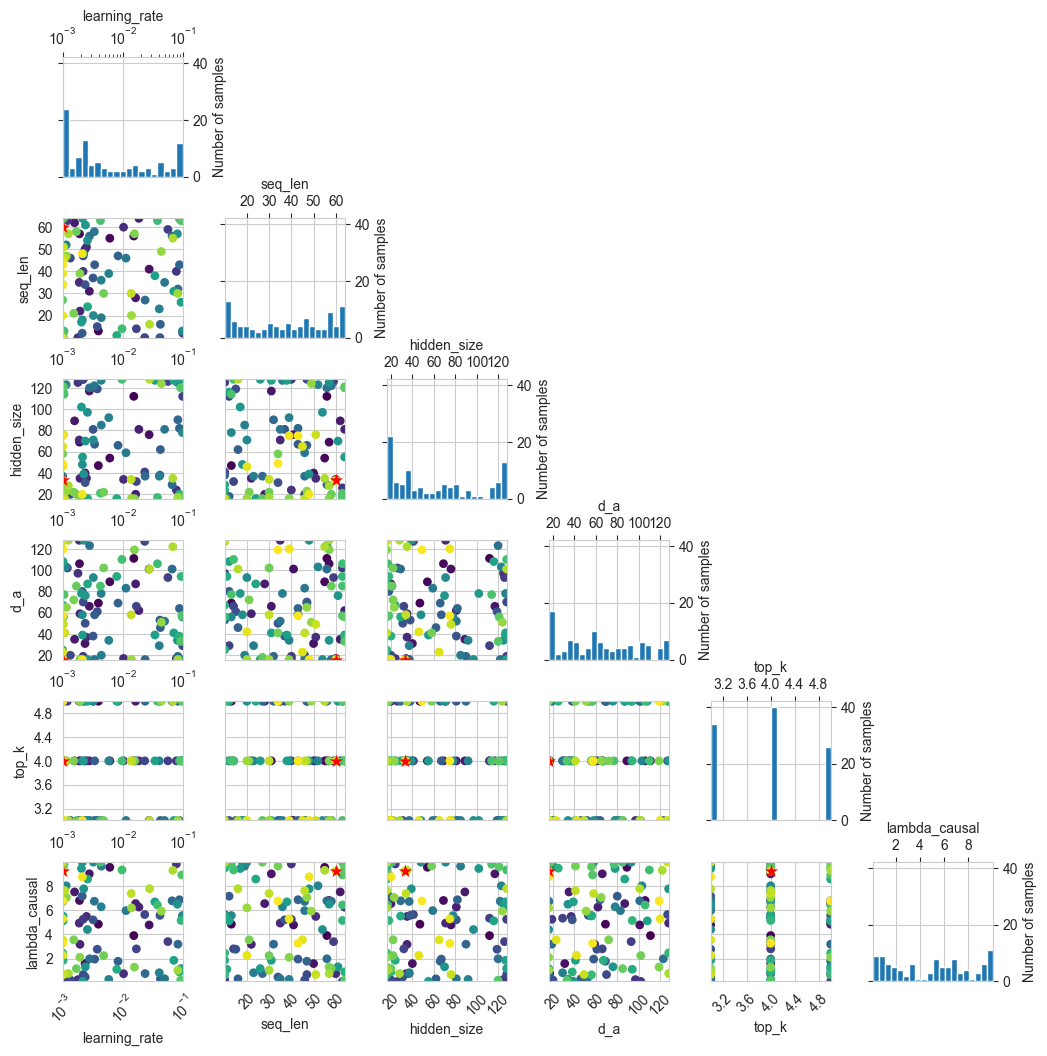

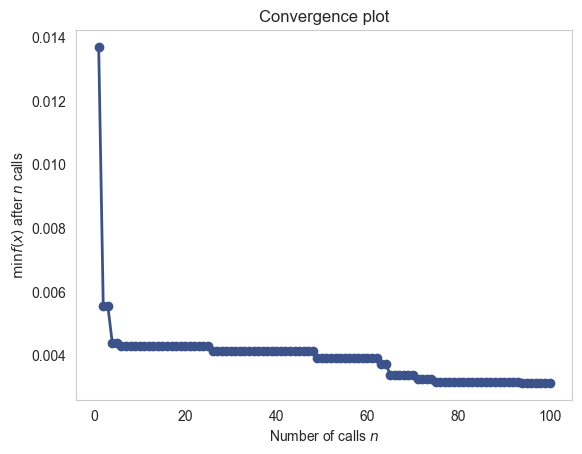

最优超参数: [0.001, np.int64(60), np.int64(33), np.int64(16), np.int64(4), 9.273466110437912]
最小验证损失: 0.0031318456090441045


In [22]:
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt
from skopt.plots import plot_evaluations
import os
from datetime import datetime
# 创建保存目录（如果不存在）
output_dir = "skopt_plots_svg"
os.makedirs(output_dir, exist_ok=True)

# 生成时间戳（避免文件名冲突）
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 绘制超参数评估点
plot_evaluations(result)
plt.savefig(f"{output_dir}/param_evaluations_{timestamp}.svg", format='svg', bbox_inches='tight')
plt.show()
plt.close()

# 绘制收敛曲线
plot_convergence(result)
plt.savefig(f"{output_dir}/convergence_curve_{timestamp}.svg", format='svg', bbox_inches='tight')
plt.show()
plt.close()

print("最优超参数:", result.x)
print("最小验证损失:", result.fun)

In [9]:

# ---------------------------
# 5. 模型训练
# ---------------------------

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs, att_weights = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {np.mean(epoch_losses):.4f}")
    # 可选：打印当前批次的注意力权重，观察稀疏效果
    # print(att_weights)

Epoch 1/50, Loss: 0.9568
Epoch 2/50, Loss: 0.8316
Epoch 3/50, Loss: 0.8149
Epoch 4/50, Loss: 0.8012
Epoch 5/50, Loss: 0.7901
Epoch 6/50, Loss: 0.7815
Epoch 7/50, Loss: 0.7743
Epoch 8/50, Loss: 0.7716
Epoch 9/50, Loss: 0.7635
Epoch 10/50, Loss: 0.7569
Epoch 11/50, Loss: 0.7522
Epoch 12/50, Loss: 0.7518
Epoch 13/50, Loss: 0.7462
Epoch 14/50, Loss: 0.7412
Epoch 15/50, Loss: 0.7456
Epoch 16/50, Loss: 0.7369
Epoch 17/50, Loss: 0.7344
Epoch 18/50, Loss: 0.7287
Epoch 19/50, Loss: 0.7291
Epoch 20/50, Loss: 0.7258
Epoch 21/50, Loss: 0.7254
Epoch 22/50, Loss: 0.7187
Epoch 23/50, Loss: 0.7157
Epoch 24/50, Loss: 0.7170
Epoch 25/50, Loss: 0.7090
Epoch 26/50, Loss: 0.7065
Epoch 27/50, Loss: 0.7067
Epoch 28/50, Loss: 0.7042
Epoch 29/50, Loss: 0.6983
Epoch 30/50, Loss: 0.6976
Epoch 31/50, Loss: 0.6951
Epoch 32/50, Loss: 0.6934
Epoch 33/50, Loss: 0.6881
Epoch 34/50, Loss: 0.6901
Epoch 35/50, Loss: 0.6843
Epoch 36/50, Loss: 0.6814
Epoch 37/50, Loss: 0.6768
Epoch 38/50, Loss: 0.6771
Epoch 39/50, Loss: 0.

In [189]:

# ---------------------------
# 6. 测试与评估
# ---------------------------
from sklearn.metrics import r2_score

model.eval()
predictions = []
ground_truth = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        output, att_weights = model(X_batch)
        predictions.append(output.cpu().numpy())
        ground_truth.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)  # (样本数, pred_steps)
ground_truth = np.concatenate(ground_truth, axis=0)  # (样本数, pred_steps)

# 反标准化
predictions_inv = predictions * scaler.scale_[df.columns.get_loc(target_col)] + scaler.mean_[
    df.columns.get_loc(target_col)]
ground_truth_inv = ground_truth * scaler.scale_[df.columns.get_loc(target_col)] + scaler.mean_[
    df.columns.get_loc(target_col)]

mse = mean_squared_error(ground_truth_inv, predictions_inv)
mae = mean_absolute_error(ground_truth_inv, predictions_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((ground_truth_inv - predictions_inv) / ground_truth_inv)) * 100
r2 = r2_score(ground_truth_inv, predictions_inv)
print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}％")

Test MSE: 0.6028, MAE: 0.6135, RMSE: 0.7764, R²: -0.1498, MAPE: 95.2179％


In [190]:

# ---------------------------
# 7. 绘制实际值与预测值的曲线
# ---------------------------

# plt.figure(figsize=(20, 6))
# plt.plot(ground_truth_inv[:, 0], label="Actual")
# plt.plot(predictions_inv[:, 0], label="Predicted")
# plt.xlabel("Time step")
# plt.ylabel(target_col)
# plt.title(f"{target_col}")
# plt.legend()
# plt.show()


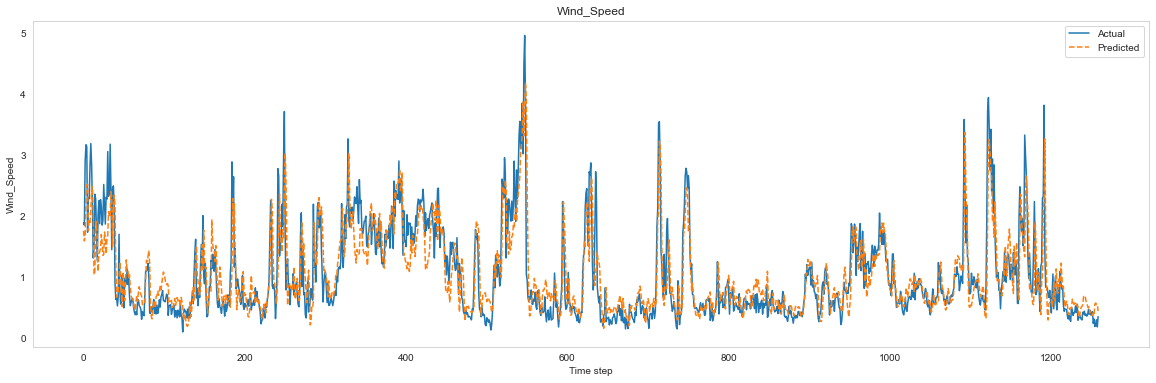

In [191]:
# ... existing code ...

# ---------------------------
# 7. 绘制实际值与预测值的曲线
# ---------------------------

import os
import pandas as pd

# 创建保存目录
os.makedirs('048', exist_ok=True)

plt.figure(figsize=(20, 6))
plt.plot(ground_truth_inv[:, 0], label="Actual", linestyle='-')
plt.plot(predictions_inv[:, 0], label="Predicted", linestyle='--')
plt.xlabel("Time step")
plt.ylabel(target_col)
plt.title(f"{target_col}")
plt.legend()
plt.grid(False)  # 移除网格线
plt.gca().set_facecolor('white')  # 设置干净背景

# 保存为SVG格式
plt.savefig('048/Wind_Speed.svg', format='svg', bbox_inches='tight')
plt.show()

In [192]:

# 保存为CSV文件
results_df = pd.DataFrame({
    'Actual': ground_truth_inv[:, 0],
    'Predicted': predictions_inv[:, 0]
})
results_df.to_csv('048/Wind_Speed.csv', index=False)

In [193]:

# 计算R²分数（取消注释并修正）
r2 = r2_score(ground_truth_inv, predictions_inv)
print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


Test MSE: 0.6028, MAE: 0.6135, RMSE: 0.7764, R²: -0.1498
